In [1]:
from ml_prediction_segmentation import config

2025-08-16 13:48:52.844 | INFO     | ml_prediction_segmentation.config:<module>:11 - PROJ_ROOT path is: /home/edyn/Documentos/obsidian-doc/Projects/MachineLearningEngineer/Curso2/Proyecto/Repo/sales_store_prediction_segmentation


In [2]:
config.RAW_DATA_DIR

PosixPath('/home/edyn/Documentos/obsidian-doc/Projects/MachineLearningEngineer/Curso2/Proyecto/Repo/sales_store_prediction_segmentation/data/raw')

# ================================
# 1. Importar librerías
# ================================

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================================
# 2. Cargar datasets originales
# ================================

In [ ]:
# source: https://www.kaggle.com/competitions/store-sales-time-series-forecasting

sales = pd.read_csv(f"{config.RAW_DATA_DIR}/train.csv", parse_dates=["date"])
stores = pd.read_csv(f"{config.RAW_DATA_DIR}/stores.csv")
oil = pd.read_csv(f"{config.RAW_DATA_DIR}/oil.csv", parse_dates=["date"])
holidays = pd.read_csv(f"{config.RAW_DATA_DIR}/holidays_events.csv", parse_dates=["date"])
transactions = pd.read_csv(f"{config.RAW_DATA_DIR}/transactions.csv", parse_dates=["date"])

print("Datasets cargados correctamente.")

Datasets cargados correctamente.


# ================================
# 3. Revisar valores nulos
# ================================

In [5]:
print("\nValores nulos en cada dataset:")
print("Sales:\n", sales.isnull().sum())
print("Oil:\n", oil.isnull().sum())
print("Holidays:\n", holidays.isnull().sum())
print("Transactions:\n", transactions.isnull().sum())


Valores nulos en cada dataset:
Sales:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
Oil:
 date           0
dcoilwtico    43
dtype: int64
Holidays:
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
Transactions:
 date            0
store_nbr       0
transactions    0
dtype: int64


In [ ]:
# Revisar valores nulos en la columna 'dcoilwtico' del dataset de petróleo
null_dcoilwtico = oil[oil['dcoilwtico'].isnull()]
null_dcoilwtico.shape

(43, 2)

In [7]:
# Rellenar nulos de precios de petróleo (ejemplo: forward fill)
oil["dcoilwtico"].fillna(method="ffill", inplace=True)
print("Oil:\n", oil.isnull().sum())

Oil:
 date          0
dcoilwtico    1
dtype: int64


/tmp/ipykernel_89881/4103000526.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  oil["dcoilwtico"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_89881/4103000526.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil["dcoilwtico"].fillna(method="ffill", inplace=True)


In [ ]:
# Visualizar las primeras filas donde originalmente había nulos en 'dcoilwtico'
oil.loc[null_dcoilwtico.index, ['date', 'dcoilwtico']].head()

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,95.61
34,2013-02-18,95.95
63,2013-03-29,97.24
104,2013-05-27,93.84


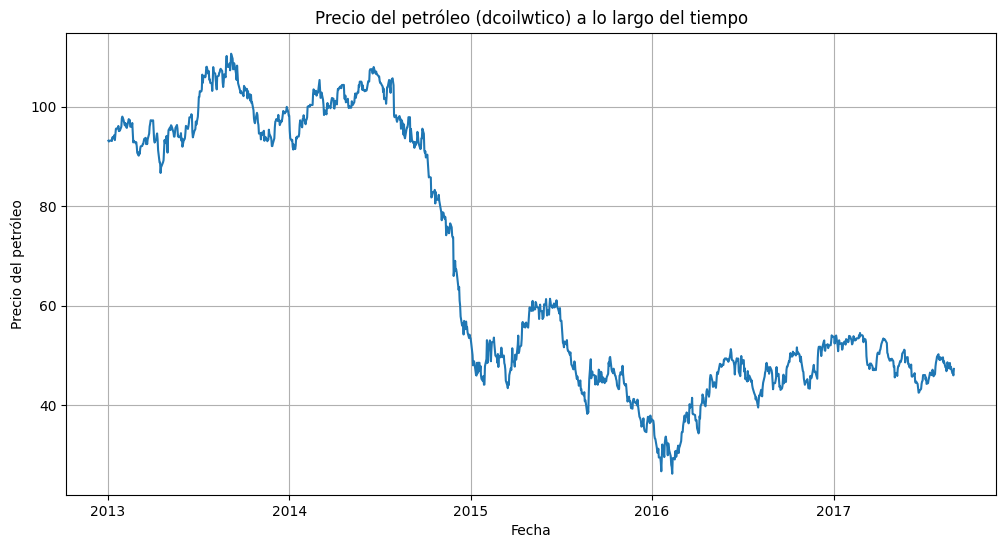

In [ ]:
# Graficar la evolución del precio del petróleo a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(oil['date'], oil['dcoilwtico'])
plt.title('Precio del petróleo (dcoilwtico) a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio del petróleo')
plt.grid(True)
plt.show()

# ================================
# 4. Unir datasets complementarios
# ================================

In [10]:
# Add prefixes
sales_prefixed = sales.add_prefix('sales_')
stores_prefixed = stores.add_prefix('stores_')
transactions_prefixed = transactions.add_prefix('trans_')
oil_prefixed = oil.add_prefix('oil_')
holidays_prefixed = holidays.add_prefix('holidays_')

# Restore 'store_nbr' & 'date' columns without prefix in DataFrames
sales_prefixed = sales_prefixed.rename(columns={'sales_store_nbr': 'store_nbr', 'sales_date': 'date'})
stores_prefixed = stores_prefixed.rename(columns={'stores_store_nbr': 'store_nbr'})
transactions_prefixed = transactions_prefixed.rename(columns={'trans_store_nbr': 'store_nbr', 'trans_date': 'date'})
oil_prefixed = oil_prefixed.rename(columns={'oil_date': 'date'})
holidays_prefixed = holidays_prefixed.rename(columns={'holidays_date': 'date'})

# Merge ventas con tiendas (por tienda)
df1 = sales_prefixed.merge(
    stores_prefixed,
    on="store_nbr",
    how="left"
)

# Merge con transacciones (por tienda y fecha)
df2 = df1.merge(
    transactions_prefixed, 
    on=["date", "store_nbr"],
    how="left"
)

# Merge con precios de petróleo (por fecha)
df3 = df2.merge(
    oil_prefixed, 
    on="date",
    how="left"
)

# Merge con feriados (por fecha)
df4 = df3.merge(
    holidays_prefixed, 
    on="date", 
    how="left"
)

print("\nDataset integrado shape:", df4.shape)


Dataset integrado shape: (3054348, 17)


# ================================
# 5. Guardar versión limpia
# ================================

In [11]:
# Formato parquet para Databricks o uso eficiente
# uv add pyarrow
df4.to_parquet(f"{config.PROCESSED_DATA_DIR}/favorita_clean.parquet", index=False)

print("✅ Dataset limpio guardado en 'favorita_clean.parquet'")

✅ Dataset limpio guardado en 'favorita_clean.parquet'
